# Set up Colab Environment



In [5]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=99e5c924655aa0e7892f131e3126f1672b4e551caed98d9c3e7909083bcc6ff6
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


# Mount Google Drive & Extract Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Music_data.zip'
extract_path = '/content/music_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check folder structure
os.listdir(extract_path)

['Music_data']

# EDA

## Basic Dataset Overview

In [38]:
import pandas as pd
import pretty_midi
import os

# Collect metadata
data = []

for composer in composer_folders:
    folder_path = os.path.join(extract_path, composer)
    for file in os.listdir(folder_path):
        if file.endswith('.mid'):
            try:
                midi = pretty_midi.PrettyMIDI(os.path.join(folder_path, file))
                num_notes = sum([len(instr.notes) for instr in midi.instruments])
                duration = midi.get_end_time()
                avg_pitch = np.mean([note.pitch for instr in midi.instruments for note in instr.notes])
                data.append({
                    'Composer': composer,
                    'Filename': file,
                    'NumNotes': num_notes,
                    'Duration': duration,
                    'AvgPitch': avg_pitch
                })
            except:
                continue

df = pd.DataFrame(data)
df.head()

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


,Composer,Filename,NumNotes,Duration,AvgPitch
0,Bach,Piano version of Bachs two part inventions No....,902,69.811861,63.062084
1,Bach,"Clavierubung Part 111,Duet No.2 in F Major.mid",1476,163.297104,62.031843
2,Bach,Bwv0963 Sonata.mid,3367,515.662760,64.756460
3,Bach,Bwv0570 Fantasia.mid,1506,201.590000,60.214475
4,Bach,Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid,748,93.000000,56.748663


##  Files per Composer (Class Balance)

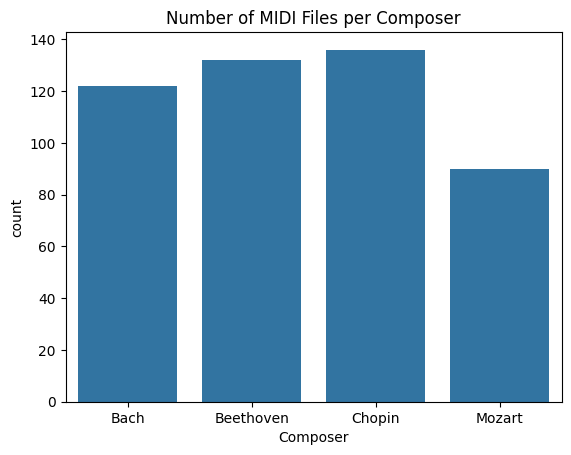

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Composer')
plt.title('Number of MIDI Files per Composer')
plt.show()

## Distribution of Composition Duration

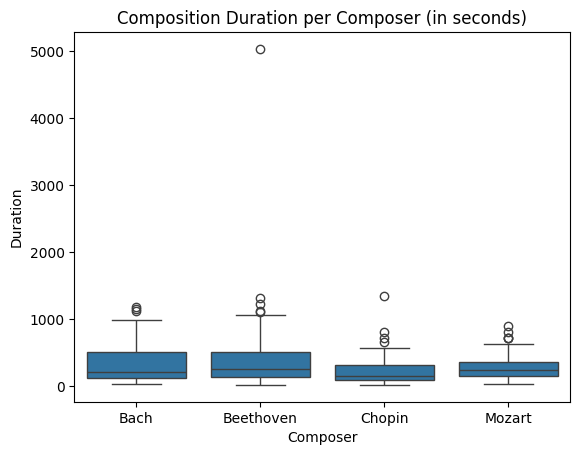

In [21]:
sns.boxplot(data=df, x='Composer', y='Duration')
plt.title('Composition Duration per Composer (in seconds)')
plt.show()

## Number of Notes per Composition

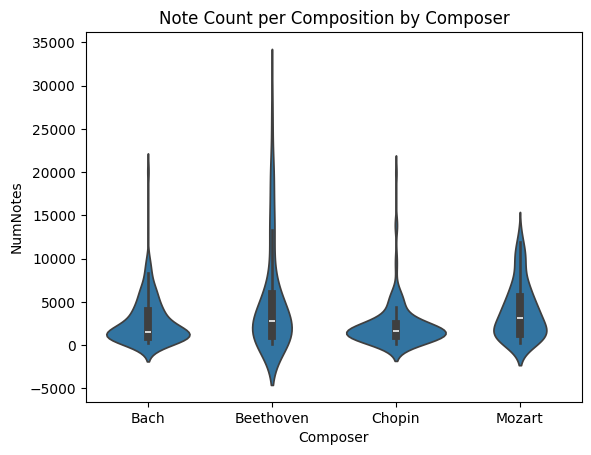

In [22]:
sns.violinplot(data=df, x='Composer', y='NumNotes')
plt.title('Note Count per Composition by Composer')
plt.show()

## Average Pitch Distribution

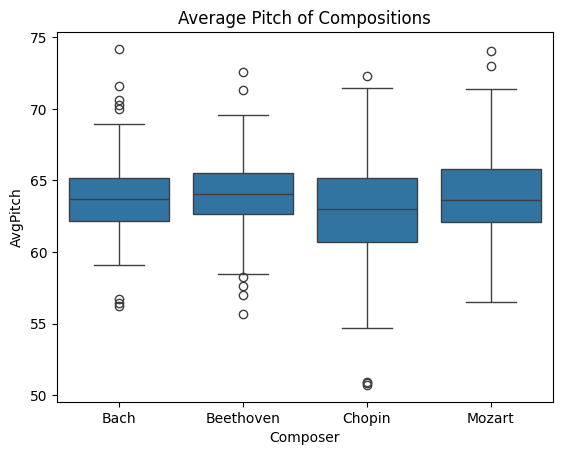

In [23]:
sns.boxplot(data=df, x='Composer', y='AvgPitch')
plt.title('Average Pitch of Compositions')
plt.show()

## Average Pitch Class Histogram

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


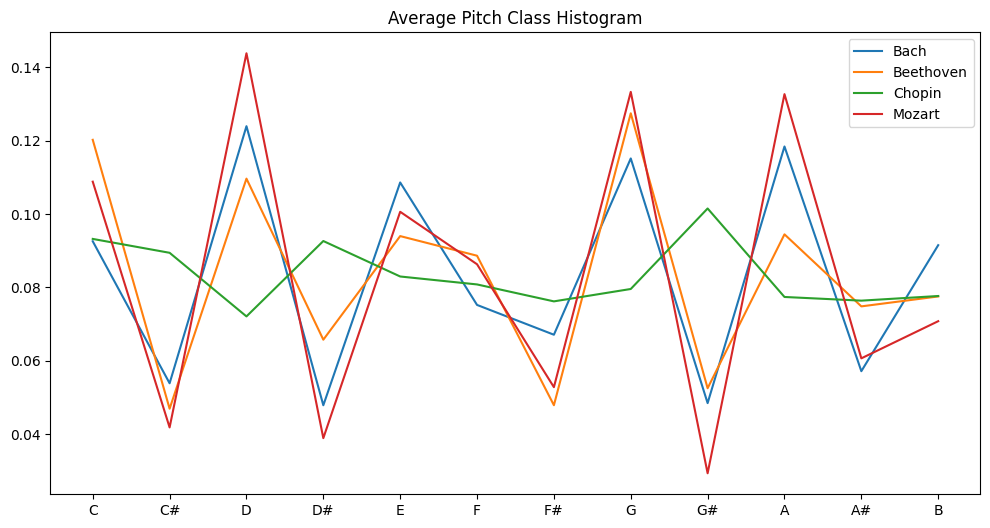

In [24]:
def pitch_class_histogram(midi_file):
    midi = pretty_midi.PrettyMIDI(midi_file)
    pitch_classes = np.zeros(12)
    for instrument in midi.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    return pitch_classes / np.sum(pitch_classes)

# Compute average pitch class histograms for each composer
pitch_histograms = {composer: np.zeros(12) for composer in composer_folders}
counts = {composer: 0 for composer in composer_folders}

for row in df.itertuples():
    file_path = os.path.join(extract_path, row.Composer, row.Filename)
    try:
        pitch_histograms[row.Composer] += pitch_class_histogram(file_path)
        counts[row.Composer] += 1
    except:
        continue

for composer in composer_folders:
    pitch_histograms[composer] /= counts[composer]

# Plot pitch class histogram
plt.figure(figsize=(12, 6))
labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

for composer in composer_folders:
    plt.plot(labels, pitch_histograms[composer], label=composer)

plt.title("Average Pitch Class Histogram")
plt.legend()
plt.show()

# Preprocess MIDI Files

In [6]:
import pretty_midi
import numpy as np

def midi_to_note_sequence(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    notes.append(note.pitch)
        return notes
    except Exception as e:
        print(f"Error with {midi_file}: {e}")
        return []

# Feature Extraction

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

extract_path = '/content/music_data/Music_data'
composer_folders = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
all_sequences = []
all_labels = []

for composer in composer_folders:
    folder_path = os.path.join(extract_path, composer)
    for file in os.listdir(folder_path):
        if file.endswith('.mid'):
            path = os.path.join(folder_path, file)
            note_seq = midi_to_note_sequence(path)
            if len(note_seq) >= 100:  # filter very short compositions
                all_sequences.append(note_seq[:100])  # truncate or pad to fixed size
                all_labels.append(composer)

# Convert to numpy
X = np.array(all_sequences)
le = LabelEncoder()
y_encoded = le.fit_transform(all_labels)
y = to_categorical(y_encoded)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error with /content/music_data/Music_data/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


# Prepare Input for Models

In [13]:
# For LSTM
X_lstm = X.reshape((X.shape[0], X.shape[1], 1))

# For CNN
X_cnn = X.reshape((X.shape[0], X.shape[1], 1, 1))

# Build LSTM and CNN Models


In [30]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D

model_cnn = Sequential([
    Conv2D(32, (3,1), activation='relu', input_shape=(100, 1, 1)),
    MaxPooling2D((2,1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,804 (393.77 KB)

 Trainable params: 100,804 (393.77 KB)

 Non-trainable params: 0 (0.00 B)

# Train and Evaluate

In [25]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [31]:
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_cnn, y_test)
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2606 - loss: 16.5070 - val_accuracy: 0.2083 - val_loss: 3.0208
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2016 - loss: 1.9739 - val_accuracy: 0.2396 - val_loss: 1.3863
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3090 - loss: 1.3832 - val_accuracy: 0.2396 - val_loss: 1.3865
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3060 - loss: 1.3844 - val_accuracy: 0.2396 - val_loss: 1.3871
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3043 - loss: 1.3819 - val_accuracy: 0.2396 - val_loss: 1.3877
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3034 - loss: 1.3805 - val_accuracy: 0.2396 - val_loss: 1.3884
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3080 - loss: 1.3784 - val_accuracy: 0.2396 - val_loss: 1.3892
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2864 - loss: 1.3787 - val_accuracy: 0.2396 - val_lo

In [32]:
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print(f"CNN Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2474 - loss: 1.3981 
CNN Accuracy: 22.92%


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential([
    LSTM(128, input_shape=(100, 1), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,076 (293.27 KB)

 Trainable params: 75,076 (293.27 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from sklearn.model_selection import train_test_split

X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Train LSTM
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.2553 - loss: 1.4294 - val_accuracy: 0.2292 - val_loss: 1.4337
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.2885 - loss: 1.3757 - val_accuracy: 0.2188 - val_loss: 1.4134
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2871 - loss: 1.3777 - val_accuracy: 0.2292 - val_loss: 1.4057
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3289 - loss: 1.3472 - val_accuracy: 0.2604 - val_loss: 1.4104
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3621 - loss: 1.3337 - val_accuracy: 0.2500 - val_loss: 1.4042
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.3827 - loss: 1.3304 - val_accuracy: 0.2812 - val_loss: 1.3900
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3225 - loss: 1.3540 - val_accuracy: 0.2708 - val_loss: 1.4107
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3256 - loss: 1.3691 - val_accuracy: 0.2604 -

In [17]:
loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test)
print(f"LSTM Accuracy: {accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.3464 - loss: 1.3712
LSTM Accuracy: 30.21%


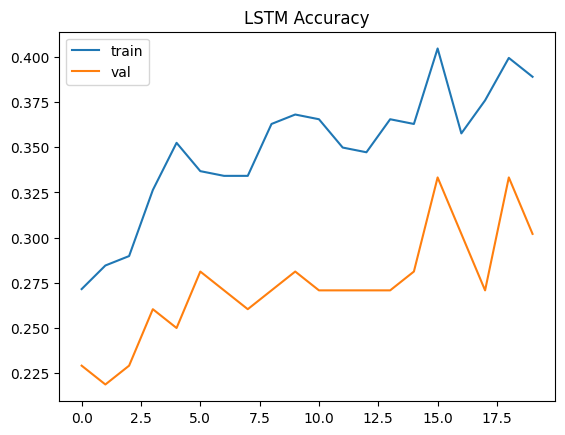

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_lstm.history['accuracy'], label='train')
plt.plot(history_lstm.history['val_accuracy'], label='val')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_cnn = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(100, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),

    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 98, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 49, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 47, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 23, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_cnn, y_test)
)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.2649 - loss: 18.1058 - val_accuracy: 0.1875 - val_loss: 1.4280
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2502 - loss: 1.8278 - val_accuracy: 0.2292 - val_loss: 1.3863
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3129 - loss: 1.3943 - val_accuracy: 0.2292 - val_loss: 1.3868
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2910 - loss: 1.3952 - val_accuracy: 0.2292 - val_loss: 1.3873
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3182 - loss: 1.4005 - val_accuracy: 0.2292 - val_loss: 1.3880
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2555 - loss: 1.3866 - val_accuracy: 0.2292 - val_loss: 1.3886
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3193 - loss: 1.3820 - val_accuracy: 0.2292 - val_loss: 1.3895
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2822 - loss: 1.3752 - val_accuracy: 0.2292 - 

In [28]:
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print(f"CNN Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2474 - loss: 1.3981 
CNN Accuracy: 22.92%


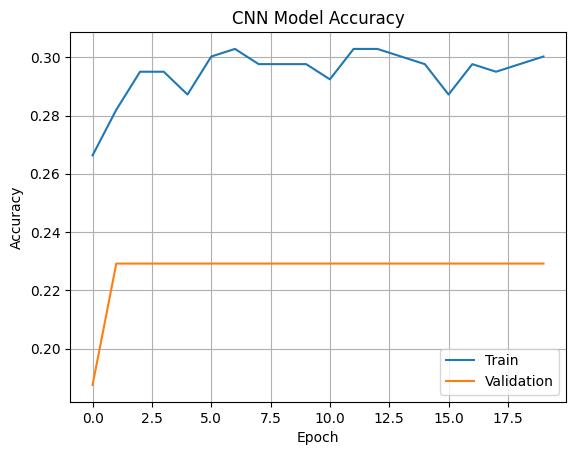

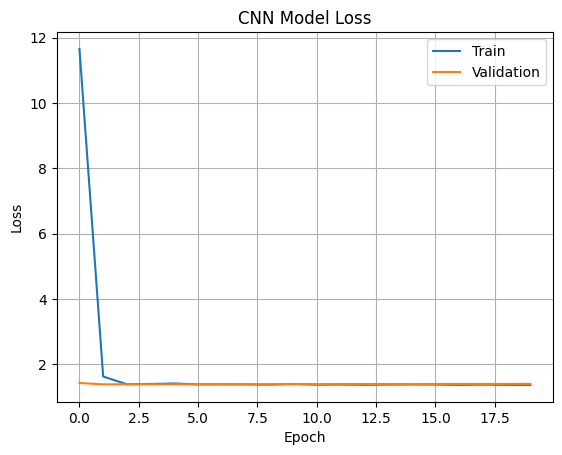

In [29]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, Dense, Dropout,
                                     Conv1D, GlobalMaxPooling1D, Input, MultiHeadAttention,
                                     Add, LayerNormalization, GlobalAveragePooling1D)

# Simulated data — replace with real MIDI note sequence data
num_samples = 100
sequence_length = 100
X = np.random.randint(0, 128, (num_samples, sequence_length))  # MIDI notes as integers
y_labels = np.random.choice(['Bach', 'Beethoven', 'Chopin', 'Mozart'], num_samples)

le = LabelEncoder()
y = to_categorical(le.fit_transform(y_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Embedding + BiLSTM Model

In [34]:
def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=128, output_dim=64, input_length=sequence_length),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

bilstm_model = build_bilstm_model()
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.3043 - loss: 1.3851 - val_accuracy: 0.1000 - val_loss: 1.3919
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2964 - loss: 1.3796 - val_accuracy: 0.1000 - val_loss: 1.3943
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3460 - loss: 1.3668 - val_accuracy: 0.1000 - val_loss: 1.4016
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3028 - loss: 1.3556 - val_accuracy: 0.1000 - val_loss: 1.4112
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3139 - loss: 1.3431 - val_accuracy: 0.1000 - val_loss: 1.4247
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3351 - loss: 1.3158 - val_accuracy: 0.1000 - val_loss: 1.4491
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4059 - loss: 1.2679 - val_accuracy: 0.1000 - val_loss: 1.5058
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3514 - loss: 1.2189 - val_accuracy: 0.1000 - val_loss: 1.5092
Epoch 9/20

# 1D CNN with Embeddings

In [35]:
def build_cnn1d_model():
    model = Sequential([
        Embedding(input_dim=128, output_dim=64, input_length=sequence_length),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn1d_model = build_cnn1d_model()
cnn1d_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.1625 - loss: 1.4039 - val_accuracy: 0.1000 - val_loss: 1.3945
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3663 - loss: 1.3603 - val_accuracy: 0.1000 - val_loss: 1.4165
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4153 - loss: 1.3416 - val_accuracy: 0.1000 - val_loss: 1.4398
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3618 - loss: 1.3230 - val_accuracy: 0.1000 - val_loss: 1.4599
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2741 - loss: 1.3283 - val_accuracy: 0.1000 - val_loss: 1.4668
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3184 - loss: 1.2935 - val_accuracy: 0.1000 - val_loss: 1.4753
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3330 - loss: 1.2724 - val_accuracy: 0.1000 - val_loss: 1.4795
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3380 - loss: 1.2366 - val_accuracy: 0.1000 - val_loss: 1.4771


# Transformer-Based Model

In [36]:
def build_transformer_model():
    inputs = Input(shape=(sequence_length,))
    x = Embedding(128, 64)(inputs)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.2200 - loss: 1.3875 - val_accuracy: 0.1000 - val_loss: 1.4695
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2306 - loss: 1.3440 - val_accuracy: 0.1000 - val_loss: 1.5512
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3415 - loss: 1.3218 - val_accuracy: 0.1000 - val_loss: 1.5207
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3910 - loss: 1.2724 - val_accuracy: 0.1000 - val_loss: 1.5355
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3878 - loss: 1.2474 - val_accuracy: 0.1500 - val_loss: 1.6223
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5174 - loss: 1.1846 - val_accuracy: 0.1000 - val_loss: 1.5676
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5927 - loss: 1.0805 - val_accuracy: 0.0500 - val_loss: 1.6401
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6868 - loss: 0.9746 - val_accuracy: 0.0000e+00 - val_loss: 1.

In [37]:
def evaluate_model(name, model):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} Accuracy: {acc:.2f}, Loss: {loss:.2f}")

evaluate_model("BiLSTM", bilstm_model)
evaluate_model("1D CNN", cnn1d_model)
evaluate_model("Transformer", transformer_model)

BiLSTM Accuracy: 0.15, Loss: 2.46
1D CNN Accuracy: 0.10, Loss: 1.44
Transformer Accuracy: 0.00, Loss: 4.23
